create_data_loaders(args)

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [8]:
def rgb2grayscale(rgb):
    return rgb[:, :, 0] * 0.2989 + rgb[:, :, 1] * 0.587 + rgb[:, :, 2] * 0.114


class DenseToSparse:
    def __init__(self):
        pass

    def dense_to_sparse(self, rgb, depth):
        pass

    def __repr__(self):
        pass


In [9]:
class UniformSampling(DenseToSparse):
    name = "uar"

    def __init__(self, num_samples, max_depth=np.inf):
        DenseToSparse.__init__(self)
        self.num_samples = num_samples
        self.max_depth = max_depth

    def __repr__(self):
        return "%s{ns=%d,md=%f}" % (self.name, self.num_samples, self.max_depth)

    def dense_to_sparse(self, rgb, depth):
        """
        Samples pixels with `num_samples`/#pixels probability in `depth`.
        Only pixels with a maximum depth of `max_depth` are considered.
        If no `max_depth` is given, samples in all pixels
        """
        prob = float(self.num_samples) / n_keep
        print(self.num_samples)
        print(n_keep)
        print(prob)
        return np.bitwise_and(mask_keep, np.random.uniform(0, 1, depth.shape) < prob)


In [10]:
sparsifier = UniformSampling(num_samples=10, max_depth=1)

In [11]:
print(sparsifier)

uar{ns=10,md=1.000000}


In [239]:
def h5_loader(path):
    h5f = h5py.File(path, "r")
    print(list(h5f.keys()))
    rgb = np.array(h5f['rgb'])
    rgb = np.transpose(rgb, (1, 2, 0))
    depth = np.array(h5f['depth'])
    return rgb, depth

In [13]:
import h5py

In [240]:
rgb, depth = h5_loader('./data/nyudepthv2/train/bedroom_0004/00001.h5')

['depth', 'rgb']


In [15]:
print(rgb.shape)

(480, 640, 3)


In [16]:
print(depth.shape)

(480, 640)


In [17]:
print(depth)

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        1.8124526 1.8124526 ... 1.6751456 1.6751456 0.       ]
 [0.        1.8124526 1.8124526 ... 1.6751456 1.6751456 0.       ]
 [0.        1.8124526 1.8124526 ... 1.6751456 1.6751456 0.       ]]


sampling 1 random

In [19]:
mask_keep = depth > 0

In [20]:
print(mask_keep)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False  True  True ...  True  True False]
 [False  True  True ...  True  True False]
 [False  True  True ...  True  True False]]


In [21]:
n_keep = np.count_nonzero(mask_keep)

In [22]:
print(n_keep)

299216


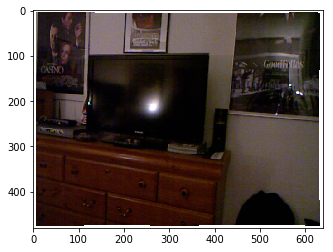

In [23]:
img_rgb = plt.imshow(rgb)

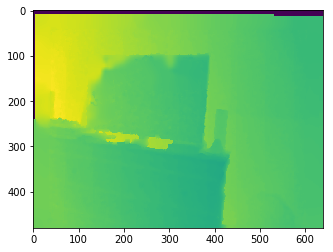

In [24]:
img_depth = plt.imshow(depth)

In [25]:
def dense_to_sparse1(rgb, depth):
        """
        Samples pixels with `num_samples`/#pixels probability in `depth`.
        Only pixels with a maximum depth of `max_depth` are considered.
        If no `max_depth` is given, samples in all pixels
        """
        num_samples = 100
        prob = float(num_samples) / n_keep
        print(num_samples)
        print(n_keep)
        print(prob)
        return np.bitwise_and(mask_keep, np.random.uniform(0, 1, depth.shape) < prob)

In [26]:
mask1 = dense_to_sparse1(rgb, depth)

100
299216
0.0003342067269129993


In [27]:
sparse_depth1 = np.zeros(depth.shape)

In [28]:
sparse_depth1[mask1] = depth[mask1]

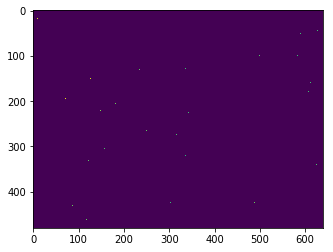

In [29]:
img_sparse1 = plt.imshow(sparse_depth1)

sampling 2 stereo

In [30]:
import cv2

In [41]:
import dataloaders.transforms as transforms

In [43]:
iheight, iwidth = 480, 640  # raw image size

In [48]:
    def train_transform(rgb, depth):
        output_size = (228, 304)
        s = np.random.uniform(1.0, 1.5)  # random scaling
        depth_np = depth / s
        angle = np.random.uniform(-5.0, 5.0)  # random rotation degrees
        do_flip = np.random.uniform(0.0, 1.0) < 0.5  # random horizontal flip

        # perform 1st step of data augmentation
        transform = transforms.Compose([
            transforms.Resize(250.0 / iheight),  # this is for computational efficiency, since rotation can be slow
            transforms.Rotate(angle),
            transforms.Resize(s),
            transforms.CenterCrop(output_size),
            transforms.HorizontalFlip(do_flip)
        ])
        rgb_np = transform(rgb)
        color_jitter = transforms.ColorJitter(0.4, 0.4, 0.4)
        rgb_np = color_jitter(rgb_np)  # random color jittering
        rgb_np = np.asfarray(rgb_np, dtype='float') / 255
        depth_np = transform(depth_np)

        return rgb_np, depth_np

In [65]:
    def dense_to_sparse2(rgb, depth):
        gray = rgb2grayscale(rgb)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        gx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)
        gy = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)

        depth_mask = np.bitwise_and(depth != 0.0, depth <= np.inf)

        num_samples = 100
        edge_fraction = float(num_samples) / np.size(depth)

        mag = cv2.magnitude(gx, gy)
        min_mag = np.percentile(mag[depth_mask], 100 * (1.0 - edge_fraction))
        mag_mask = mag >= min_mag

        mask = np.bitwise_and(mag_mask, depth_mask)
        return mask

In [50]:
rgb_np, depth_np = train_transform(rgb, depth)

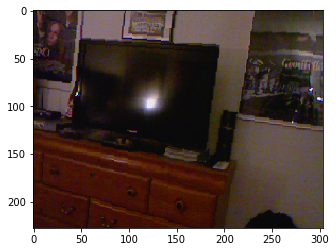

In [53]:
img_rgb = plt.imshow(rgb_np)

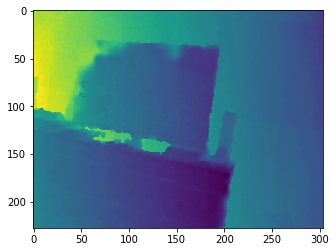

In [54]:
img_rgb = plt.imshow(depth_np)

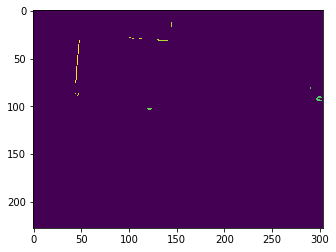

In [66]:
mask2 = dense_to_sparse2(rgb_np, depth_np)
sparse_depth2 = np.zeros(depth_np.shape)
sparse_depth2[mask2] = depth_np[mask2]
img_sparse2 = plt.imshow(sparse_depth2)

sampling 3 reflector

In [131]:
blurred = cv2.GaussianBlur(rgb_np, (5, 5), 0)
depth_test = depth_np.reshape((-1,3))
K = 8
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(depth_test,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

In [107]:
print(ret)
print(label)
print(center)

190.27990097371548
[[0]
 [0]
 [0]
 ...
 [2]
 [2]
 [2]]
[[2.0581012 2.055651  2.0526056]
 [1.827326  1.826106  1.8234   ]
 [1.581301  1.5811528 1.5812706]
 [1.4063413 1.4059753 1.4064093]
 [1.7020698 1.6988189 1.6951244]
 [1.50061   2.1117873 2.118929 ]
 [1.5116915 1.5189309 2.0222533]
 [1.4953163 1.4953163 2.1562505]]


In [108]:
print(depth_np)
print(depth_np.shape)

[[2.085686  2.085686  2.085686  ... 1.4910069 1.4910069 1.4910069]
 [2.085686  2.085686  2.085686  ... 1.4910069 1.4910069 1.4910069]
 [2.085686  2.085686  2.085686  ... 1.4910069 1.4910069 1.4910069]
 ...
 [1.7237074 1.7237074 1.7237074 ... 1.5599551 1.5599551 1.5599551]
 [1.7237074 1.7237074 1.7237074 ... 1.5599551 1.5599551 1.5599551]
 [1.7150888 1.7150888 1.7150888 ... 1.5599551 1.5599551 1.5599551]]
(228, 304)


In [109]:
print(label.shape)
print(center.shape)

(23104, 1)
(8, 3)


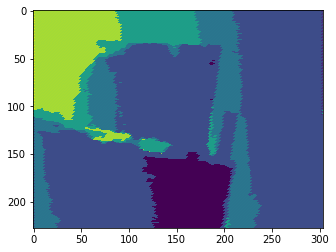

In [110]:
res = center[label.flatten()]
res2 = res.reshape((depth_np.shape))
plt.imshow(res2)

In [111]:
print(res)
print(res.shape)

[[2.0581012 2.055651  2.0526056]
 [2.0581012 2.055651  2.0526056]
 [2.0581012 2.055651  2.0526056]
 ...
 [1.581301  1.5811528 1.5812706]
 [1.581301  1.5811528 1.5812706]
 [1.581301  1.5811528 1.5812706]]
(23104, 3)


In [102]:
a0 = label.ravel()==0;
print(a0)
A = depth_test[a0]
print(A.shape)

[False False False ... False False False]
(8209, 1)


In [121]:
print(depth_test)
print(depth_test.shape)
depth_sparse = depth_test.reshape((depth_np.shape))
print(depth_sparse)
print(depth_sparse.shape)
a0 = a0.reshape((depth_np.shape))
print(a0)
print(a0.shape)

[[2.085686  2.085686  2.085686 ]
 [2.085686  2.068449  2.0512118]
 [2.0598304 2.068449  2.0770676]
 ...
 [1.5685737 1.5685737 1.5685737]
 [1.5599551 1.5599551 1.5599551]
 [1.5599551 1.5599551 1.5599551]]
(23104, 3)
[[2.085686  2.085686  2.085686  ... 1.4910069 1.4910069 1.4910069]
 [2.085686  2.085686  2.085686  ... 1.4910069 1.4910069 1.4910069]
 [2.085686  2.085686  2.085686  ... 1.4910069 1.4910069 1.4910069]
 ...
 [1.7237074 1.7237074 1.7237074 ... 1.5599551 1.5599551 1.5599551]
 [1.7237074 1.7237074 1.7237074 ... 1.5599551 1.5599551 1.5599551]
 [1.7150888 1.7150888 1.7150888 ... 1.5599551 1.5599551 1.5599551]]
(228, 304)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(228, 304)


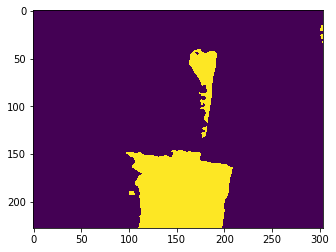

In [126]:
plt.imshow(a0)

In [127]:
idx = np.where(a0)
print(idx)
print(idx[0].shape)
x0 = np.median(idx[0])
y0 = np.median(idx[1])
print(x0,y0)


(array([ 16,  16,  17, ..., 227, 227, 227]), array([302, 303, 302, ..., 195, 196, 197]))
(8209,)
182.0 162.0


In [230]:
def dense_to_sparse3(rgb, depth):
#         gray = np.float32(rgb2grayscale(rgb))
        gray = np.float32(rgb)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        depth_test = blurred.reshape((-1,3))
        num_samples = 10
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret,label,center=cv2.kmeans(depth_test,num_samples,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
        
        mask = np.full(depth.shape, False)
        for i in range(num_samples):
            a0 = label.ravel() == i
            a0 = a0.reshape((depth.shape))
            idx = np.where(a0)
#             print(idx)
            x0 = np.mean(idx[0]).astype(np.int)
            y0 = np.mean(idx[1]).astype(np.int)
#             print(i, x0, y0)
            mask[x0, y0] = True
        return mask,label,center

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(228, 304)


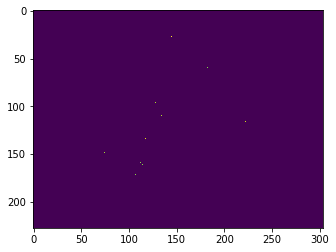

In [231]:
mask3,label,center = dense_to_sparse3(rgb_np, depth_np)
print(mask3)
print(mask3.shape)
sparse_depth3 = np.zeros(depth_np.shape)
sparse_depth3[mask3] = depth_np[mask3]
img_sparse3 = plt.imshow(sparse_depth3)

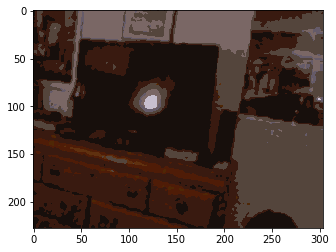

In [233]:
res = center[label.flatten()]
res2 = res.reshape((rgb_np.shape))
plt.imshow(res2)

In [134]:
blurred = cv2.GaussianBlur(rgb_np, (5, 5), 0)
depth_test = rgb_np.reshape((-1,3))
K = 8
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(depth_test,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/core/src/kmeans.cpp:239: error: (-215:Assertion failed) data0.dims <= 2 && type == 5 && K > 0 in function 'kmeans'


In [72]:
print(Z.shape)

(50, 2)


In [73]:
print(depth_np.shape)

(228, 304)


In [ ]:
# # initialize the list of threshold methods
# methods = [
#     ("THRESH_BINARY", cv2.THRESH_BINARY),
#     ("THRESH_BINARY_INV", cv2.THRESH_BINARY_INV),
#     ("THRESH_TRUNC", cv2.THRESH_TRUNC),
#     ("THRESH_TOZERO", cv2.THRESH_TOZERO),
#     ("THRESH_TOZERO_INV", cv2.THRESH_TOZERO_INV)]
 
# # loop over the threshold methods
# for (threshName, threshMethod) in methods:
#     # threshold the image and show it
#     (T, thresh) = cv2.threshold(depth_np, args["threshold"], 255, threshMethod)
#     cv2.imshow(threshName, thresh)

In [ ]:
# blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# dx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)
# dy = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)
# bmsk = sqrt(dx.^2+dy.^2) > 5; 
# # using morphological operations to "complete" the contours around the cars
# bmsk = bwmorph( bwmorph(bmsk, 'dilate', ones(7)), 'skel'); 

# % once the contours are complete, use connected components
# cars = bwlabel(~bmsk,4);  % segmentation mask
# st = regionprops(cars, 'Area', 'BoundingBox');
# % display the results
# figure;
# imshow(img);
# hold all;
# for ii=2:numel(st),  % ignore the first segment - it's the background
#     if st(ii).Area>200, % ignore small regions as "noise"
#         rectangle('Position',st(ii).BoundingBox, 'LineWidth', 3, 'EdgeColor', 'g');
#     end;
# end;

#### sampling 4 wireless

In [259]:
def transmap(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return int(rightMin + (valueScaled * rightSpan))

In [353]:
def gaussian_peak(size, sigma):
#     mu, sigma = 0, 0.1 # mean and standard deviation
#     s = np.random.normal(mu, sigma, 2*size*30)
#     count, bins, ignored = plt.hist(s, 2*size, normed=True)
#     return count
    mean = [0, 0]
    cov = [[10*sigma, 0], [0, 10*sigma]]  
    x, y = np.random.multivariate_normal(mean, cov, 300*size).T
    xedges = np.linspace(-size,size, 2*size+1)
    yedges = np.linspace(-size,size, 2*size+1)
    H, _, _ = np.histogram2d(y, x, bins=(xedges, yedges))
#     print(H)
    return H

In [381]:
def makeGaussian(size, fwhm = 10):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """
    x = np.linspace(-size, size, 2*size)
    y = x[:,np.newaxis]

    return np.exp(-4*np.log(2) * (x**2 + y**2) / fwhm**2)

19
6
19
3
9
5
16
18
10
19
(228, 304)


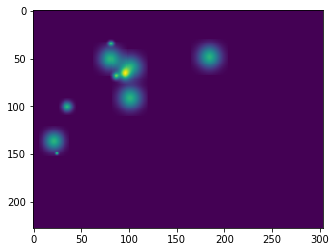

In [405]:
gray = np.float32(rgb_np)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
depth_test = blurred.reshape((-1,3))
num_samples = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(depth_test,num_samples,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
        
spectrum = np.zeros(depth_np.shape)
for i in range(num_samples):
    a0 = label.ravel() == i
    a0 = a0.reshape((depth_np.shape))
    idx = np.where(a0)
    x0 = np.mean(idx[0]).astype(np.int)
    s0 = np.sum(a0).astype(np.int)
#     print(s0)
    y0 = np.mean(idx[1]).astype(np.int)
    dd = depth_np[x0, y0]
#     print(dd)
    z0 = transmap(dd, np.min(depth_np), np.max(depth_np), 0, 227)
#     print(z0)
    rang = min(np.floor(2*np.log(s0)).astype(np.int), 30)
    print(rang)
    spectrum[z0-rang:z0+rang, x0-rang:x0+rang] += makeGaussian(rang,rang)
print(spectrum.shape)
img_sparse3 = plt.imshow(spectrum)

In [262]:
np.min(depth_np)

1.3272548

In [263]:
np.max(depth_np)

2.197727

In [272]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]  # diagonal covariance
x, y = np.random.multivariate_normal(mean, cov, 20).T

In [273]:
print(x.shape)
print(x)
print(y.shape)
print(y)

(20,)
[ 1.38491344 -0.04532346  0.32116703  0.30399644  1.40136022  0.0262551
 -1.62839479  0.23210707 -0.4774001  -1.28817331 -1.9248259  -0.28902356
  0.70990163  0.14454274 -0.56918588 -0.60199457 -1.37301595  1.6071883
  2.79765551 -1.51886841]
(20,)
[ -2.64272026   6.96378495  -6.60869031  -4.13230939  -2.89773711
   2.05258004   4.19440347  23.12123471   1.50520807 -10.62126142
  -5.38019406  -3.33163105 -17.75257458  15.77583306   1.66420566
  19.85836173  15.69514032  -3.84073119  18.73680735  13.44841111]


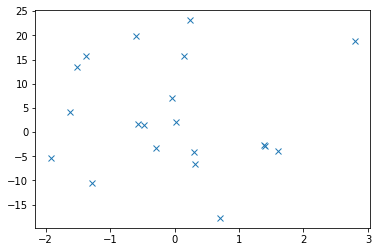

In [274]:
plt.plot(x, y, 'x')

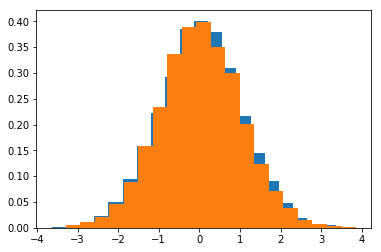

In [343]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  
x, y = np.random.multivariate_normal(mean, cov, 5000).T
count, bins, ignored = plt.hist(x, 20, normed=True)
count, bins, ignored = plt.hist(y, 20, normed=True)

In [344]:
xedges = np.linspace(-5,5,11)
yedges = np.linspace(-5,5,11)
H, xedges, yedges = np.histogram2d(y, x, bins=(xedges, yedges))

In [310]:
print(H)

[[ 0.  0.  4. 25. 45. 74. 18.  5.  0.  0.]
 [ 0.  1.  6. 36. 74. 61. 31.  2.  0.  0.]
 [ 0.  0.  4. 23. 63. 70. 31.  6.  1.  0.]
 [ 0.  0.  4. 19. 56. 79. 24.  3.  0.  0.]
 [ 0.  0.  3. 22. 75. 88. 35.  5.  0.  0.]
 [ 0.  1.  5. 26. 68. 66. 27.  6.  0.  0.]
 [ 0.  2.  0. 23. 77. 75. 22.  2.  0.  0.]
 [ 0.  0.  2. 36. 62. 71. 28.  3.  0.  0.]
 [ 0.  1.  6. 27. 68. 52. 25.  4.  0.  0.]
 [ 0.  0.  5. 19. 62. 81. 24.  7.  0.  0.]]


In [359]:
x = np.linspace(-5, 5, 11)
y = x[:,np.newaxis]
a = np.exp(-4*np.log(2) * (x**2 + y**2) / 3**2)
print(a)

[[2.04382892e-07 3.27012628e-06 2.82554539e-05 1.31843230e-04
  3.32224121e-04 4.52087262e-04 3.32224121e-04 1.31843230e-04
  2.82554539e-05 3.27012628e-06 2.04382892e-07]
 [3.27012628e-06 5.23220204e-05 4.52087262e-04 2.10949168e-03
  5.31558594e-03 7.23339619e-03 5.31558594e-03 2.10949168e-03
  4.52087262e-04 5.23220204e-05 3.27012628e-06]
 [2.82554539e-05 4.52087262e-04 3.90625000e-03 1.82270162e-02
  4.59292029e-02 6.25000000e-02 4.59292029e-02 1.82270162e-02
  3.90625000e-03 4.52087262e-04 2.82554539e-05]
 [1.31843230e-04 2.10949168e-03 1.82270162e-02 8.50493750e-02
  2.14310996e-01 2.91632260e-01 2.14310996e-01 8.50493750e-02
  1.82270162e-02 2.10949168e-03 1.31843230e-04]
 [3.32224121e-04 5.31558594e-03 4.59292029e-02 2.14310996e-01
  5.40029869e-01 7.34867246e-01 5.40029869e-01 2.14310996e-01
  4.59292029e-02 5.31558594e-03 3.32224121e-04]
 [4.52087262e-04 7.23339619e-03 6.25000000e-02 2.91632260e-01
  7.34867246e-01 1.00000000e+00 7.34867246e-01 2.91632260e-01
  6.25000000e-02

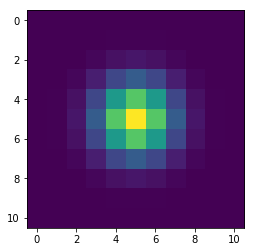

In [360]:
plt.imshow(a)